In [ ]:
!pip install transformers

In [ ]:
# Importing

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
from keras.datasets import imdb
from keras.layers import LSTM, Activation, Dropout, Dense, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.models import Model
import string
import re
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.model_selection import train_test_split

import urllib.request

from IPython.display import display, HTML

# **Does bias in embeddings diffuse to downstream tasks?**

### GloVe

*   Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased, 25d, 50d, 100d, & 200d vectors, 1.42 GB download):
https://nlp.stanford.edu/data/glove.twitter.27B.zip
*   Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors, 822 MB download): https://nlp.stanford.edu/data/glove.6B.zip



### Results:
* The Twitter embedding used in the GloVe model contains considerable bias in sentiment prediction results between female-associated words and male-associated words compared to the Wikipedia and Gigaword embedding used to train the GloVe model.
* Among sentiment prediction scoring between female-associated words and male-associated words using the Twitter embedding to train our GloVe model, we see a disproportionately higher prediction proportion of female-associated words as negative compared to male-associated words, and a disproportionately lower prediction proportion of female-associated words as positive compared to male-associated words, indicating the potential flow of bias into downstream tasks for sentiment prediction. 
* On the other hand, we see a much more uniform landscape of sentiment prediction scores among female-associated words and male-associated words when using the Wikipedia and Gigaword embeddings to train our GloVe model. This considerable discrepancy in predicted sentiment scores between the two GloVe models trained on the Twitter and Wikipedia and Gigaword embeddings supports our hypothesis that bias in embeddings may have effects that transfer to downstream tasks (e.g. sentiment prediction in our example use case).  


In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

data = load_dataset("tweet_eval", "sentiment")

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset tweet_eval downloaded and prepared to /root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Define set of male-associated and female-associated words to be used in our analysis

male_words = ['he', 'male', 'man', 'father', 'boy', 'husband']
female_words = ['she', 'female', 'woman', 'mother', 'girl', 'wife']

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
data['train'][0]

{'label': 2,
 'text': '"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"'}

In [ ]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
 
 
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [ ]:
import gensim.downloader as api

model = api.load("glove-twitter-25")
model.most_similar(positive=['fruit', 'flower'], topn=1)

[==================================================] 100.0% 104.8/104.8MB downloaded


[('cherry', 0.9183273911476135)]

In [ ]:
# Download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

In [ ]:
data = pd.read_csv('IMDB Dataset.csv')

data['review'] = data['review'].str.lower()

In [ ]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", 
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]

In [ ]:
def remove_stopwords(data):
  data['review without stopwords'] = data['review'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords)]))
  return data

def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result
    
data_without_stopwords = remove_stopwords(data)
data_without_stopwords['clean_review']= data_without_stopwords['review without stopwords'].apply(lambda cw : remove_tags(cw))
data_without_stopwords['clean_review'] = data_without_stopwords['clean_review'].str.replace('[{}]'.format(string.punctuation), ' ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
data_without_stopwords.head()

,review,sentiment,review without stopwords,clean_review
0,one of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching just 1 oz epi...,one reviewers mentioned watching just 1 oz epi...
1,a wonderful little production. <br /><br />the...,positive,wonderful little production. <br /><br />the f...,wonderful little production the filming techn...
2,i thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,thought wonderful way spend time hot summer we...
3,basically there's a family where a little boy ...,negative,basically family little boy (jake) thinks zomb...,basically family little boy jake thinks zomb...
4,"petter mattei's ""love in the time of money"" is...",positive,"petter mattei's ""love time money"" visually stu...",petter mattei s love time money visually stu...


In [ ]:
reviews = data_without_stopwords['clean_review']
reviews

0        one reviewers mentioned watching just 1 oz epi...
1        wonderful little production  the filming techn...
2        thought wonderful way spend time hot summer we...
3        basically family little boy  jake  thinks zomb...
4        petter mattei s  love time money  visually stu...
                               ...                        
49995    thought movie right good job  wasn t creative ...
49996    bad plot  bad dialogue  bad acting  idiotic di...
49997    catholic taught parochial elementary schools n...
49998    going disagree previous comment side maltin on...
49999    no one expects star trek movies high art  fans...
Name: clean_review, Length: 50000, dtype: object

In [ ]:
reviews_list = []
for i in range(len(reviews)):
  reviews_list.append(reviews[i])
 
sentiment = data_without_stopwords['sentiment']

In [ ]:
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, sentiment)))

y

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(reviews_list, y, test_size=0.2, random_state = 45)

In [ ]:
len(Y_train)

40000

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

In [ ]:
words_to_index = tokenizer.word_index

len(words_to_index)

95419

In [ ]:
def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
  return word_to_vec_map

In [ ]:
# Glove Twitter
word_to_vec_map = read_glove_vector('glove.twitter.27B.50d.txt')

In [ ]:
maxLen = 150

In [ ]:
vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    emb_matrix[index, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)

In [ ]:
def model_build(input_shape):

  X_indices = Input(input_shape)

  embeddings = embedding_layer(X_indices)

  X = LSTM(128, return_sequences=True)(embeddings)

  X = Dropout(0.6)(X)

  X = LSTM(128, return_sequences=True)(X)

  X = Dropout(0.6)(X)

  X = LSTM(128)(X)

  X = Dense(1, activation='sigmoid')(X)

  model = Model(inputs=X_indices, outputs=X)

  return model

In [ ]:
def conv1d_model(input_shape):

  X_indices = Input(input_shape)

  embeddings = embedding_layer(X_indices)

  X = Conv1D(512,3,activation='relu')(embeddings)
  
  X = MaxPooling1D(3)(X)

  X = Conv1D(256,3,activation='relu')(X)
  
  X = MaxPooling1D(3)(X)

  X = Conv1D(256,3,activation='relu')(X)
  X = Dropout(0.8)(X)
  X = MaxPooling1D(3)(X)

  X = GlobalMaxPooling1D()(X)

  X = Dense(256, activation='relu')(X)
  X = Dense(1, activation='sigmoid')(X)

  model = Model(inputs=X_indices, outputs=X)

  return model

In [ ]:
model = model_build((maxLen,))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           4770950   
                                                                 
 lstm (LSTM)                 (None, 150, 128)          91648     
                                                                 
 dropout (Dropout)           (None, 150, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 150, 128)          131584    
                                                                 
 dropout_1 (Dropout)         (None, 150, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584

In [ ]:
model_1d = conv1d_model((maxLen,))
model_1d.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           4770950   
                                                                 
 conv1d (Conv1D)             (None, 148, 512)          77312     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 512)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 256)           393472    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 15, 256)          0         
 1D)                                                       

In [ ]:
X_train_indices = tokenizer.texts_to_sequences(X_train)

In [ ]:
X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')
X_train_indices.shape

(40000, 150)

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model_1d.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model_1d.fit(X_train_indices, Y_train, batch_size=64, epochs=15)

Epoch 1/15
625/625 [==============================] - 207s 329ms/step - loss: 0.5492 - accuracy: 0.7128
Epoch 2/15
625/625 [==============================] - 204s 326ms/step - loss: 0.4530 - accuracy: 0.7870
Epoch 3/15
625/625 [==============================] - 203s 324ms/step - loss: 0.4101 - accuracy: 0.8110
Epoch 4/15
625/625 [==============================] - 203s 324ms/step - loss: 0.3836 - accuracy: 0.8268
Epoch 5/15
625/625 [==============================] - 204s 326ms/step - loss: 0.3571 - accuracy: 0.8414
Epoch 6/15
625/625 [==============================] - 203s 325ms/step - loss: 0.3320 - accuracy: 0.8554
Epoch 7/15
625/625 [==============================] - 202s 323ms/step - loss: 0.3112 - accuracy: 0.8677
Epoch 8/15
625/625 [==============================] - 202s 324ms/step - loss: 0.2910 - accuracy: 0.8766
Epoch 9/15
625/625 [==============================] - 204s 326ms/step - loss: 0.2641 - accuracy: 0.8902
Epoch 10/15
625/625 [==============================] - 203s 325m

In [ ]:
model_1d.save_weights('twitter_weights_1d.hdf5')

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train_indices, Y_train, batch_size=64, epochs=10)

Epoch 1/10
625/625 [==============================] - 579s 925ms/step - loss: 0.5702 - accuracy: 0.6933
Epoch 2/10
625/625 [==============================] - 579s 926ms/step - loss: 0.4674 - accuracy: 0.7815
Epoch 3/10
625/625 [==============================] - 576s 922ms/step - loss: 0.4442 - accuracy: 0.7927
Epoch 4/10
625/625 [==============================] - 576s 922ms/step - loss: 0.4292 - accuracy: 0.8010
Epoch 5/10
625/625 [==============================] - 573s 917ms/step - loss: 0.4079 - accuracy: 0.8149
Epoch 6/10
625/625 [==============================] - 573s 917ms/step - loss: 0.3922 - accuracy: 0.8231
Epoch 7/10
625/625 [==============================] - 581s 929ms/step - loss: 0.3792 - accuracy: 0.8317
Epoch 8/10
625/625 [==============================] - 577s 924ms/step - loss: 0.3655 - accuracy: 0.8394
Epoch 9/10
625/625 [==============================] - 577s 923ms/step - loss: 0.3575 - accuracy: 0.8428
Epoch 10/10
625/625 [==============================] - 571s 913m

In [ ]:
model.save_weights('twitter_weights.hdf5')

In [ ]:
# GloVe Twitter (Female Words)

female_words_indices = tokenizer.texts_to_sequences(female_words)

female_words_indices = pad_sequences(female_words_indices, maxlen=maxLen, padding='post')

In [ ]:
female_preds_twitter = model.predict(female_words_indices)

female_preds_twitter

array([[0.4279375 ],
       [0.390104  ],
       [0.44793978],
       [0.3592508 ],
       [0.48739728],
       [0.36962226]], dtype=float32)

In [ ]:
female_pred_zip = zip(female_words, female_preds_twitter)

female_scores_twitter = []

for i in female_pred_zip:
  female_scores_twitter.append(i[1][0])

female_scores_twitter

[0.4279375, 0.390104, 0.44793978, 0.3592508, 0.48739728, 0.36962226]

In [ ]:
female_twitter_df = pd.DataFrame()

female_twitter_df['Word'] = female_words
female_twitter_df['Sentiment Score'] = female_scores_twitter
female_twitter_df['Sentiment'] = ['Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative']

female_twitter_df

,Word,Sentiment Score,Sentiment
0,she,0.427938,Negative
1,female,0.390104,Negative
2,woman,0.447940,Negative
3,mother,0.359251,Negative
4,girl,0.487397,Negative
5,wife,0.369622,Negative


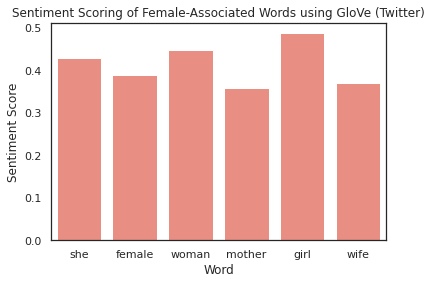

In [ ]:
# GloVe Twitter Female Words Plotting

sns.set_theme(style="white")
ax = sns.barplot(x="Word", y="Sentiment Score", data=female_twitter_df,
                 color="salmon").set(title='Sentiment Scoring of Female-Associated Words using GloVe (Twitter)')

In [ ]:
# GloVe Twitter (Male Words)

male_words_indices = tokenizer.texts_to_sequences(male_words)

male_words_indices = pad_sequences(male_words_indices, maxlen=maxLen, padding='post')

In [ ]:
male_preds_twitter = model.predict(male_words_indices)

male_preds_twitter

array([[0.21470755],
       [0.26483706],
       [0.24595451],
       [0.39093822],
       [0.4040503 ],
       [0.35941148]], dtype=float32)

In [ ]:
male_pred_zip = zip(male_words, male_preds_twitter)

male_scores_twitter = []

for i in male_pred_zip:
  male_scores_twitter.append(i[1][0])

male_scores_twitter

[0.6646749470139494,
 0.7148044500256528,
 0.6959219071770658,
 0.8409056160355558,
 0.8540176842118253,
 0.8093788716698637]

In [ ]:
male_twitter_df = pd.DataFrame()

male_twitter_df['Word'] = male_words
male_twitter_df['Sentiment Score'] = male_scores_twitter
male_twitter_df['Sentiment'] = ['Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', ]

male_twitter_df

,Word,Sentiment Score,Sentiment
0,he,0.664675,Positive
1,male,0.714804,Positive
2,man,0.695922,Positive
3,father,0.840906,Positive
4,boy,0.854018,Positive
5,husband,0.809379,Positive


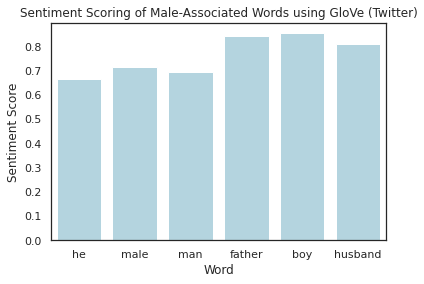

In [ ]:
# GloVe Twitter Male Words Plotting

sns.set_theme(style="white")
ax = sns.barplot(x="Word", y="Sentiment Score", data=male_twitter_df,
                 color="lightblue").set(title='Sentiment Scoring of Male-Associated Words using GloVe (Twitter)')

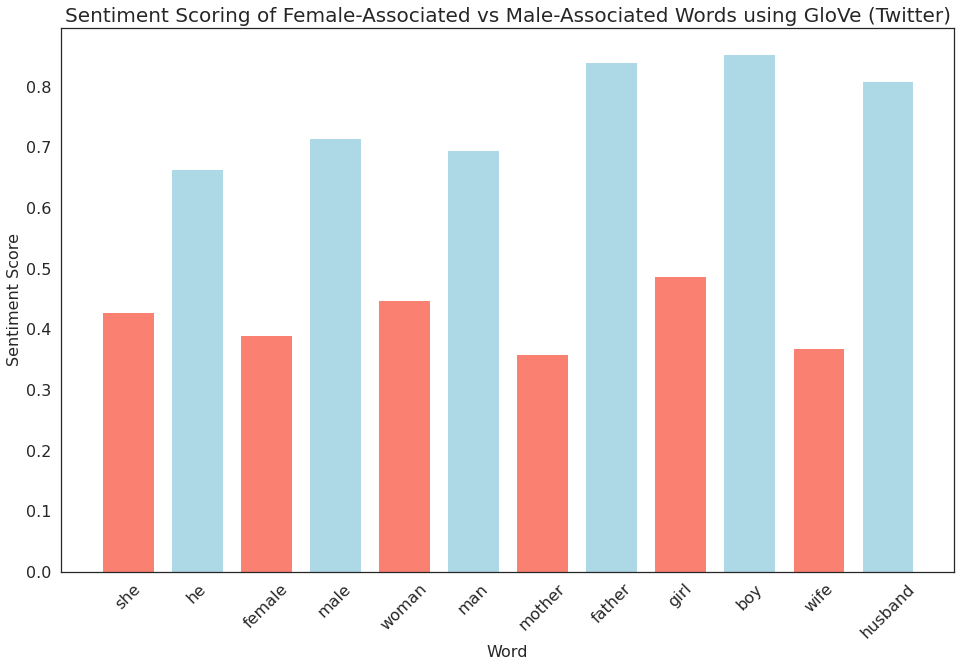

In [ ]:
# GloVe Twitter Joint Female and Male Words Plotting

female_male_key = ['she', 'he', 'female', 'male', 'woman', 'man', 'mother', 'father', 'girl', 'boy', 'wife', 'husband']
female_male_values = [0.4279375, 0.66467, 0.390104, 0.71480, 0.44793978, 0.69592, 0.3592508, 0.84090,
                      0.4873972, 0.85401, 0.36962226, 0.80937]

plt.figure(figsize = (16, 10))
plt.bar(range(len(female_male_values)), female_male_values, width = 0.75, color = ['salmon', 'lightblue'])
plt.title('Sentiment Scoring of Female-Associated vs Male-Associated Words using GloVe (Twitter)', size = 20)
plt.xlabel('Word', size = 16)
plt.ylabel('Sentiment Score', size = 16)
plt.xticks(np.arange(len(female_male_key)), female_male_key, rotation = 45, size = 16)
plt.yticks(size = 16)
plt.show()

In [ ]:
# Glove Wikipedia 2014 + Gigaword 5
word_to_vec_map_wiki = read_glove_vector('glove.6B.50d.txt')

In [ ]:
maxLen = 150

In [ ]:
vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map_wiki['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
  embedding_vector = word_to_vec_map_wiki.get(word)
  if embedding_vector is not None:
    emb_matrix[index, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)

In [ ]:
def model_build_2(input_shape):

  X_indices = Input(input_shape)

  embeddings = embedding_layer(X_indices)

  X = LSTM(128, return_sequences=True)(embeddings)

  X = Dropout(0.6)(X)

  X = LSTM(128, return_sequences=True)(X)

  X = Dropout(0.6)(X)

  X = LSTM(128)(X)

  X = Dense(1, activation='sigmoid')(X)

  model = Model(inputs=X_indices, outputs=X)

  return model

In [ ]:
model_wiki = model_build_2((maxLen,))
model_wiki.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 150, 50)           4770950   
                                                                 
 lstm_6 (LSTM)               (None, 150, 128)          91648     
                                                                 
 dropout_5 (Dropout)         (None, 150, 128)          0         
                                                                 
 lstm_7 (LSTM)               (None, 150, 128)          131584    
                                                                 
 dropout_6 (Dropout)         (None, 150, 128)          0         
                                                                 
 lstm_8 (LSTM)               (None, 128)               1315

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model_wiki.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model_wiki.fit(X_train_indices, Y_train, batch_size=64, epochs=10)

Epoch 1/10
625/625 [==============================] - 591s 946ms/step - loss: 0.4621 - accuracy: 0.7835
Epoch 2/10
625/625 [==============================] - 585s 936ms/step - loss: 0.4335 - accuracy: 0.8018
Epoch 3/10
625/625 [==============================] - 578s 925ms/step - loss: 0.4025 - accuracy: 0.8193
Epoch 4/10
625/625 [==============================] - 578s 925ms/step - loss: 0.3870 - accuracy: 0.8265
Epoch 5/10
625/625 [==============================] - 578s 925ms/step - loss: 0.3748 - accuracy: 0.8322
Epoch 6/10
625/625 [==============================] - 578s 924ms/step - loss: 0.3687 - accuracy: 0.8368
Epoch 7/10
625/625 [==============================] - 579s 926ms/step - loss: 0.3626 - accuracy: 0.8399
Epoch 8/10
625/625 [==============================] - 589s 943ms/step - loss: 0.3543 - accuracy: 0.8440
Epoch 9/10
625/625 [==============================] - 584s 934ms/step - loss: 0.3554 - accuracy: 0.8423
Epoch 10/10
625/625 [==============================] - 581s 930m

In [ ]:
model_wiki.save_weights('wiki_weights.hdf5')

In [ ]:
# GloVe Wiki (Female Words)

female_words_indices_wiki = tokenizer.texts_to_sequences(female_words)

female_words_indices_wiki = pad_sequences(female_words_indices_wiki, maxlen=maxLen, padding='post')

In [ ]:
female_preds_wiki = model_wiki.predict(female_words_indices_wiki)

female_preds_wiki

array([[0.5087178 ],
       [0.49208453],
       [0.5481335 ],
       [0.54446507],
       [0.60037535],
       [0.49044484]], dtype=float32)

In [ ]:
female_pred_zip_wiki = zip(female_words, female_preds_wiki)

female_wiki = []

for i in female_pred_zip_wiki:
  female_wiki.append(i[1][0])

female_wiki

[0.5087178, 0.49208453, 0.5481335, 0.54446507, 0.60037535, 0.49044484]

In [ ]:
female_wiki_df = pd.DataFrame()

female_wiki_df['Word'] = female_words
female_wiki_df['Sentiment Score'] = female_wiki
female_wiki_df['Sentiment'] = ['Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Negative']

female_wiki_df

,Word,Sentiment Score,Sentiment
0,she,0.508718,Positive
1,female,0.492085,Negative
2,woman,0.548133,Positive
3,mother,0.544465,Positive
4,girl,0.600375,Positive
5,wife,0.490445,Negative


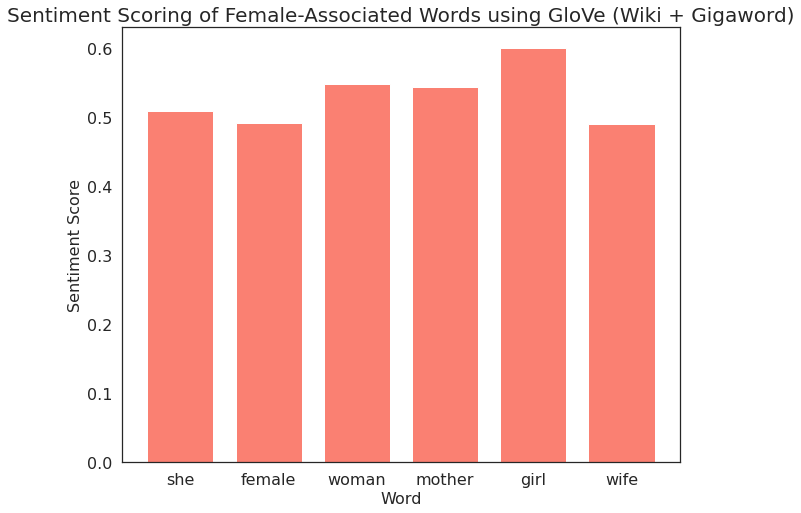

In [ ]:
# GloVe Wiki Female Words Plotting

plt.figure(figsize = (10, 8))
plt.bar(range(len(female_wiki)), female_wiki, width = 0.75, color = 'salmon')
plt.title('Sentiment Scoring of Female-Associated Words using GloVe (Wiki + Gigaword)', size = 20)
plt.xlabel('Word', size = 16)
plt.ylabel('Sentiment Score', size = 16)
plt.xticks(range(len(female_words)), female_words, size = 16)
plt.yticks(size = 16)
plt.show()

In [ ]:
# GloVe Wiki (Male Words)

male_words_indices_wiki = tokenizer.texts_to_sequences(male_words)

male_words_indices_wiki = pad_sequences(male_words_indices_wiki, maxlen=maxLen, padding='post')

In [ ]:
male_preds_wiki = model_wiki.predict(male_words_indices_wiki)

male_preds_wiki

array([[0.44838077],
       [0.5011796 ],
       [0.54984266],
       [0.49010107],
       [0.53465396],
       [0.45888868]], dtype=float32)

In [ ]:
male_pred_zip_wiki = zip(male_words, male_preds_wiki)

male_wiki = []

for i in male_pred_zip_wiki:
  male_wiki.append(i[1][0])

male_wiki

[0.44838077, 0.5011796, 0.54984266, 0.49010107, 0.53465396, 0.45888868]

In [ ]:
male_wiki_df = pd.DataFrame()

male_wiki_df['Word'] = male_words
male_wiki_df['Sentiment Score'] = male_wiki
male_wiki_df['Sentiment'] = ['Negative', 'Positive', 'Positive', 'Negative', 'Positive', 'Negative']

male_wiki_df

,Word,Sentiment Score,Sentiment
0,he,0.448381,Negative
1,male,0.501180,Positive
2,man,0.549843,Positive
3,father,0.490101,Negative
4,boy,0.534654,Positive
5,husband,0.458889,Negative


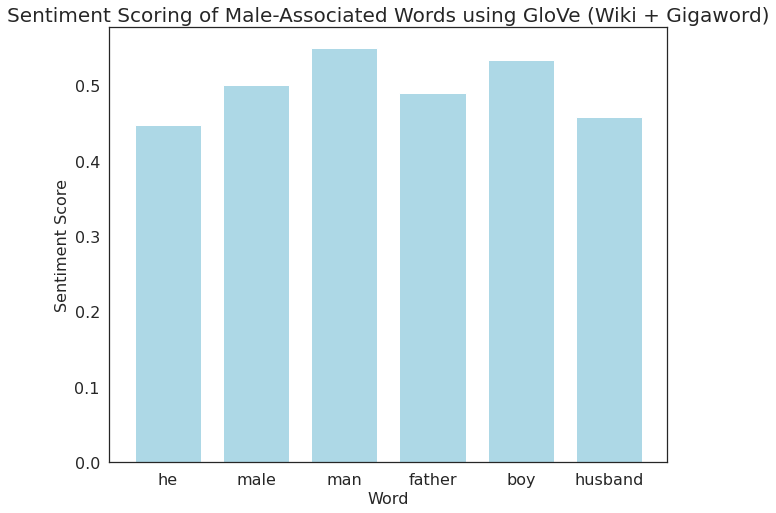

In [ ]:
# GloVe Wiki Male Words Plotting

plt.figure(figsize = (10, 8))
plt.bar(range(len(male_wiki)), male_wiki, width = 0.75, color = 'lightblue')
plt.title('Sentiment Scoring of Male-Associated Words using GloVe (Wiki + Gigaword)', size = 20)
plt.xlabel('Word', size = 16)
plt.ylabel('Sentiment Score', size = 16)
plt.xticks(range(len(male_words)), male_words, size = 16)
plt.yticks(size = 16)
plt.show()

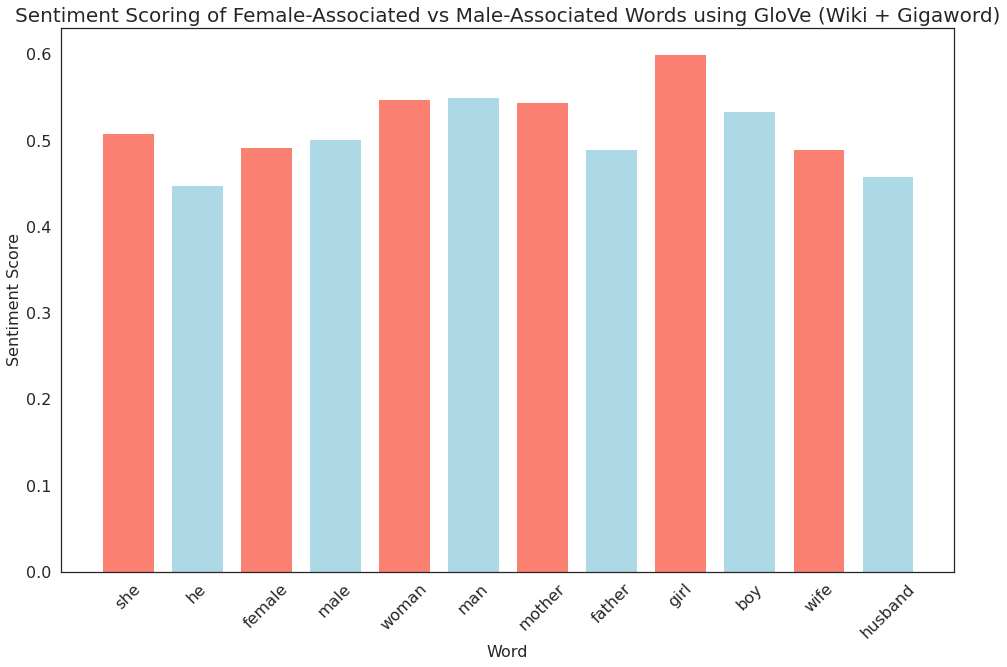

In [ ]:
# GloVe Wiki Joint Female and Male Words Plotting

female_male_key = ['she', 'he', 'female', 'male', 'woman', 'man', 'mother', 'father', 'girl', 'boy', 'wife', 'husband']
female_male_values = [0.5087178, 0.44838077,
                      0.49208453, 0.5011796,
                      0.5481335, 0.54984266,
                      0.54446507, 0.49010107,
                      0.60037535, 0.53465396,
                      0.49044484, 0.45888868]

plt.figure(figsize = (16, 10))
plt.bar(range(len(female_male_values)), female_male_values, width = 0.75, color = ['salmon', 'lightblue'])
plt.title('Sentiment Scoring of Female-Associated vs Male-Associated Words using GloVe (Wiki + Gigaword)', size = 20)
plt.xlabel('Word', size = 16)
plt.ylabel('Sentiment Score', size = 16)
plt.xticks(np.arange(len(female_male_key)), female_male_key, rotation = 45, size = 16)
plt.yticks(size = 16)
plt.show()